In [42]:
# This notebook identify the image type based in a set of different descriptors
from azure.storage.blob import BlockBlobService, PublicAccess
import sys
sys.path.append('./')

In [43]:
# Take credential and access to azure blob storage
import config_blob_keys as cfg

account_name = cfg.AccountName
account_key = cfg.AccountKey

block_blob_service = BlockBlobService(account_name=account_name, account_key=account_key)

cont_name_analysis = cfg.ContNameAnalysis
block_blob_service.set_container_acl(cont_name_analysis, public_access=PublicAccess.Container)

cont_name_desc = cfg.ContNameDesc
block_blob_service.set_container_acl(cont_name_desc, public_access=PublicAccess.Container)

cont_name_desc_cor = cfg.ContNameDescCor
block_blob_service.set_container_acl(cont_name_desc_cor, public_access=PublicAccess.Container)

In [44]:
# Functions to work with azure blobs
def BlobList(container, folder, filelist, verbose=False):
    
    gen = block_blob_service.list_blobs(container, prefix=folder)
    
    for blob in gen:
        file = str(blob.name).replace(folder,'')
        filelist.append(file)
        if verbose == True:
            print("\t Blob name: " + blob.name)
        
    return filelist

# Download a file "blobfile" from "container" and save it 
# in the file "locfile"
def DownBlob(container, blobfile, locfile, verbose=False):
    
    if verbose == True:
        print('Downloading ' + blobfile + ' to ' + locfile)
    
    block_blob_service.get_blob_to_path(container, blobfile, locfile)

    if verbose == True:
        print('Downloading ' + blobfile + ' to ' + locfile)
    

# Uncompress data 
def UnCompress(file, verbose=False):
    
    if verbose == True:
        print('Uncompressing ' + file)
    
    subprocess.call(['uncompress', file])
    #os.popen('uncompress ' + file)

# Upload file "locfile" to the blob "blobfile" in container
def UpBlob(container, blobfile, locfile, verbose=False):
    
    if verbose == True:
        print('Uploading ' + locfile + ' to ' + blobfile)
        
    block_blob_service.create_blob_from_path(container, blobfile, locfile, validate_content=True)


In [45]:
# Funtions to visualize images maps and images histograms
def DisplayHist(imgood, imbad, verbose=False):

    im_data_g = np.load(imgood)
    im_mean_g = np.mean(im_data_g)
    im_median_g = np.median(im_data_g)
    im_std_g = np.std(im_data_g)
    
    im_data_b = np.load(imbad)
    im_mean_b = np.mean(im_data_b)
    im_median_b = np.median(im_data_b)
    im_std_b = np.std(im_data_b)
        
    im_median = 0.5*(im_median_g + im_median_b)
    im_mean = 0.5*(im_mean_g + im_mean_b)
    im_std = 0.5*(im_std_g + im_std_b)
    
    print("DMean: ", (im_mean_g-im_mean_b)/im_mean_g)
    print("DMedian: ", (im_median_g-im_median_b)/im_median_g)
    print("DStdDev: ", (im_std_g-im_std_b)/im_std_g)
        
    nbins = 100
    hist, bins, _ = plt.hist(np.ndarray.flatten(im_data_g), bins=nbins)
    plt.clf()
    #plt.figure(figsize=(10, 5))
    logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
    fig, ax = plt.subplots(figsize=(8,4))
    plt.hist(np.ndarray.flatten(im_data_g), bins=logbins, range=[im_median/2, im_median*5], alpha=0.5, label = 'Good')
    plt.hist(np.ndarray.flatten(im_data_b), bins=logbins, range=[im_median/2, im_median*5], alpha=0.5, label = 'Bad')
    plt.legend()
    plt.title('Histogram')
    ax.set_yscale('log')
    plt.xscale('log')
    plt.xlabel('counts')
    plt.ylabel('# counts')
    plt.grid()
    plt.show()
    #fig.savefig(imnameb)
    
def DisplayMaps(imgood, imbad, verbose=False):
    
    im_data_g = np.load(imgood)
    im_mean_g = np.mean(im_data_g)
    im_median_g = np.median(im_data_g)
    im_std_g = np.std(im_data_g)
    
    im_data_b = np.load(imbad)
    im_mean_b = np.mean(im_data_b)
    im_median_b = np.median(im_data_b)
    im_std_b = np.std(im_data_b)
        
    im_median = 0.5*(im_median_g + im_median_b)    
    im_std = 0.5*(im_std_g + im_std_b)    
    
    fig, axrr = plt.subplots(1, 2, figsize=(10,12))
    #fig, ax = plt.subplots(figsize=(3,4))
    im = axrr[0].imshow(im_data_g, origin='lower', interpolation='nearest', vmin=im_median_g-im_std_g, vmax=im_median_g+2*im_std_g, cmap='Greys_r')
    axrr[0].set_title('Good')
    plt.tight_layout()
    axrr[0].set_xlabel('x')
    axrr[0].set_ylabel('y')

    #plt.subplot(1, 2, 2)
    #fig, ax = plt.subplots(figsize=(3,4))
    #fig, axrr = plt.subplots(1, 2, figsize=(16,8))
    im = axrr[1].imshow(im_data_b, origin='lower', interpolation='nearest', vmin=im_median_b-im_std_b, vmax=im_median_b+2*im_std_b, cmap='Greys_r')
    axrr[1].set_title('Bad')
    plt.tight_layout()
    axrr[1].set_xlabel('x')
    axrr[1].set_ylabel('y')
    
    plt.show()
    #fig.savefig(imnamea)

In [46]:
import pandas as pd
import numpy as np
#import utils_blob as ub
import os
import multiprocessing
import tqdm
import time
import random
import matplotlib.pyplot as plt
import warnings
from functools import partial

warnings.simplefilter("ignore")

In [47]:
# This cell select nsample descriptors from blob storage for a method method_dir
# The selection can be done for a given year
nsample = 100

method_dir = 'numpy/method4'

random.seed(100)
save_fig = False
select_year = False
year = '2017'

DescBlobSubDirs = ['UVES_BLUE_BIAS','UVES_RED_BIAS','UVES_BLUE_WAVE','UVES_DIC1B_FLAT','UVES_DIC1B_DFLAT','UVES_RED_WAVE','UVES_DIC1R_FLAT']
UVESimtype = 'UVES_BLUE_BIAS'
imag_dim = 11#len(DescBlobSubDirs)
desc_dim = 2048
samp_dim = nsample
cube_good = np.zeros((imag_dim,samp_dim,desc_dim))
cube_bad  = np.zeros((imag_dim,samp_dim,desc_dim))
cube      = np.zeros((imag_dim,samp_dim,desc_dim))
path_loc = '../Temp/test'
desc_name = []
i = 0

print('Taking data from ',method_dir,'.')
# Loof for images type folder
for desc_blob_sub_dir in DescBlobSubDirs:
    
    # Images extensions    
    if desc_blob_sub_dir == 'UVES_BLUE_BIAS' or desc_blob_sub_dir == 'UVES_DIC1B_FLAT' or desc_blob_sub_dir == 'UVES_DIC1B_DFLAT':
        Exten = [0]
    elif desc_blob_sub_dir == 'UVES_RED_BIAS' or desc_blob_sub_dir == 'UVES_BLUE_WAVE' or desc_blob_sub_dir == 'UVES_RED_WAVE' or desc_blob_sub_dir == 'UVES_DIC1R_FLAT':
        Exten = [1,2]
    
    # Define the image type
    if desc_blob_sub_dir == 'UVES_BLUE_BIAS':
        image_type = 'bias_blue'
        abr_name = 'UBB'
    elif desc_blob_sub_dir == 'UVES_RED_BIAS':
        image_type = 'URB'
    elif desc_blob_sub_dir == 'UVES_BLUE_WAVE' or desc_blob_sub_dir == 'UVES_DIC1B_FLAT' or desc_blob_sub_dir == 'UVES_DIC1B_DFLAT':
        image_type = 'blue_arc_flat'
        if desc_blob_sub_dir == 'UVES_BLUE_WAVE':
            abr_name = 'UBW'
        elif desc_blob_sub_dir == 'UVES_DIC1B_FLAT':
            abr_name = 'UD1BF'
        elif desc_blob_sub_dir == 'UVES_DIC1B_DFLAT':
            abr_name = 'UD1BDF'
    elif desc_blob_sub_dir == 'UVES_RED_WAVE' or desc_blob_sub_dir == 'UVES_DIC1R_FLAT':
        image_type = 'red_arc_flat'
        if desc_blob_sub_dir == 'UVES_RED_WAVE':
            abr_name = 'URW'
        elif desc_blob_sub_dir == 'UVES_DIC1R_FLAT':
            abr_name = 'UD1RF'

    # Take bad image names
    PROJECT_DIR = "/data/notebooks/uves_jprieto"
    DATA_DIR = os.path.join(PROJECT_DIR, "data")
    
    uves_flag_file=os.path.join(DATA_DIR, 'UVES_hidden_flag_results.txt')
    uves_flag_df=pd.read_csv(uves_flag_file, comment='#', sep=';')
    corrupted_df = uves_flag_df[(uves_flag_df['image_type'] == image_type) & (uves_flag_df['flag'] == 'CORRUPTED')]
    bad_files_garchim = list(corrupted_df['filename']) 
    
    # Loop for images extensions
    for ext in Exten:
        abr_name = abr_name + str(ext)
        extension = 'ext'+str(ext)
        print('Working on ' + desc_blob_sub_dir + ' extension ' + extension + '...\n')
        
        # Bad Garchim images
        # ----------------------------------------------------------------------
        desc_folder_rem = os.path.join(method_dir,desc_blob_sub_dir)
        desc_folder_rem = os.path.join(desc_folder_rem,extension)
        
        desc_files_list = []
        BlobList(cont_name_desc, desc_folder_rem, desc_files_list)
        
        desc_cor_list = []
        desc_files_list = [s for s in desc_files_list if any(xs in s for xs in bad_files_garchim)]
        
        if len(desc_files_list) >= nsample:
            desc_files_list = random.sample(desc_files_list, nsample)
        desc_badg_files = desc_files_list

        # Good images method
        # ----------------------------------------------------------------------
        desc_folder_rem = os.path.join(method_dir,desc_blob_sub_dir)
        desc_folder_rem = os.path.join(desc_folder_rem,extension)
        
        desc_files_list = []
        BlobList(cont_name_desc, desc_folder_rem, desc_files_list)
        
        desc_files_list = [s for s in desc_files_list if s not in bad_files_garchim]
        if select_year==True:
            desc_files_list = [s for s in desc_files_list if year in s]
            if len(desc_files_list) >= nsample:
                desc_files_list = random.sample(desc_files_list, nsample)
        elif select_year==False:
            if len(desc_files_list) >= nsample:
                desc_files_list = random.sample(desc_files_list, nsample)        
        desc_good_files = desc_files_list
        
        desc_temp = np.zeros(2048).T
        desc_matrix = np.expand_dims(desc_temp,axis=0)

        im_abr = []
        print('Good images...')
        with tqdm.tqdm_notebook(total=len(desc_files_list)) as pbar:
            for idx in range(len(desc_files_list)):
                
                name = abr_name + str(idx)
                im_abr.append(name)
                file = desc_files_list[idx]
                desc_blob_name = desc_folder_rem + file
                descriptor_file = path_loc + file

                DownBlob(cont_name_desc, desc_blob_name, descriptor_file, False)
                
                while not os.path.exists(descriptor_file):
                    time.sleep(0.1)

                desc_resNet50 = np.load(descriptor_file)
                np_desc = np.array(desc_resNet50)
                desc_matrix = np.vstack((desc_matrix,np_desc))
                os.remove(descriptor_file)
                pbar.update(1)
        
        desc_name.append(im_abr)
        desc_good = np.delete(desc_matrix,0,axis=0)
        cube_good[i,:,:] = desc_good 
        i+=1

Taking data from  numpy/method4 .
Working on UVES_BLUE_BIAS extension ext0...

Good images...



Working on UVES_RED_BIAS extension ext1...

Good images...



Working on UVES_RED_BIAS extension ext2...

Good images...



Working on UVES_BLUE_WAVE extension ext1...

Good images...



Working on UVES_BLUE_WAVE extension ext2...

Good images...



Working on UVES_DIC1B_FLAT extension ext0...

Good images...



Working on UVES_DIC1B_DFLAT extension ext0...

Good images...



Working on UVES_RED_WAVE extension ext1...

Good images...



Working on UVES_RED_WAVE extension ext2...

Good images...



Working on UVES_DIC1R_FLAT extension ext1...

Good images...



Working on UVES_DIC1R_FLAT extension ext2...

Good images...


In [48]:
# Parameters for clustering
from sklearn.preprocessing import normalize
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances

norm = False
method = 'single'
metric = 'cosine'
criterion = 'distance'

In [49]:
# Save descriptors data and names
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_fscore_support, homogeneity_score, v_measure_score
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.vq import whiten
import tqdm
import sys
np.set_printoptions(threshold=sys.maxsize)

#['UVES_BLUE_BIAS(0)',
#'UVES_RED_BIAS(1,2)',
#'UVES_BLUE_WAVE(1,2)',
#'UVES_DIC1B_FLAT(0)',
#'UVES_DIC1B_DFLAT(0)',
#'UVES_RED_WAVE(1,2)',
#'UVES_DIC1R_FLAT(1,2)']

UBB0    = cube_good[ 0,:,:]
URB1    = cube_good[ 1,:,:]
URB2    = cube_good[ 2,:,:]
UBW1    = cube_good[ 3,:,:]
UBW2    = cube_good[ 4,:,:]
UD1BF0  = cube_good[ 5,:,:]
UD1BDF0 = cube_good[ 6,:,:]
URW1    = cube_good[ 7,:,:]
URW2    = cube_good[ 8,:,:]
UD1RF1  = cube_good[ 9,:,:]
UD1RF2  = cube_good[10,:,:]

UBB0name    = desc_name[ 0]
URB1name    = desc_name[ 1]
URB2name    = desc_name[ 2]
UBW1name    = desc_name[ 3]
UBW2name    = desc_name[ 4]
UD1BF0name  = desc_name[ 5]
UD1BDF0name = desc_name[ 6]
URW1name    = desc_name[ 7]
URW2name    = desc_name[ 8]
UD1RF1name  = desc_name[ 9]
UD1RF2name  = desc_name[10]

#'UBB0','URB1','URB2','UBW1','UBW2','UD1BF0','UD1BDF0','URW1','URW2','UD1RF1','UD1RF2'
im_labels = ['UBB0','URB1','URB2','UBW1','UBW2','UD1BF0','UD1BDF0','URW1','URW2','UD1RF1','UD1RF2']
desc_mat  = np.vstack((UBB0,URB1,URB2,UBW1,UBW2,UD1BF0,UD1BDF0,URW1,URW2,UD1RF1,UD1RF2))
if norm==True:
    desc_mat = whiten(desc_mat)
    
names = UBB0name
names.extend(URB1name)
names.extend(URB2name)
names.extend(UBW1name)
names.extend(UBW2name)
names.extend(UD1BF0name)
names.extend(UD1BDF0name)
names.extend(URW1name)
names.extend(URW2name)
names.extend(UD1RF1name)
names.extend(UD1RF2name)

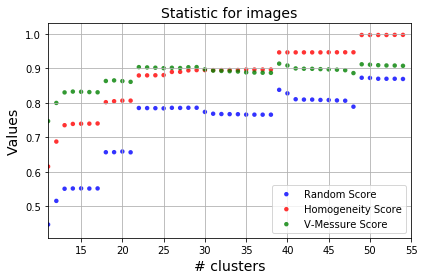

N-clusters:    49
A-R-score : 0.87304
Homo-score: 0.99713
V-M-score : 0.91214


In [50]:
# Look for optimal number of cluster to identify the image types
clt_temp = []
clt_true = []
len_list = [UD1RF2.shape[0],UD1BDF0.shape[0],URB2.shape[0],URW1.shape[0],URW2.shape[0],UD1RF2.shape[0],UD1BDF0.shape[0],URB2.shape[0],URW1.shape[0],URW2.shape[0],URW2.shape[0]]
nclt_true = len(len_list)

for ind, ndim in enumerate(len_list):
    clt_temp = ind*np.ones(ndim)
    clt_true = np.concatenate((clt_true,clt_temp))

nclti = len(len_list)
nclte = 5*nclti
nclt_list = list(np.arange(nclti,nclte))
score = []
hscore = []
vscore = []
nclusters = []

with tqdm.tqdm_notebook(total=len(nclt_list)) as pbar:    
    for nclt in nclt_list:
        model = AgglomerativeClustering(n_clusters=nclt, 
                                          affinity=metric, 
                                          linkage=method,
                                          distance_threshold=None, 
                                          compute_full_tree=False)
        clusters = model.fit(desc_mat)
        clt_pred = clusters.labels_

        rand_score = adjusted_rand_score(clt_true,clt_pred)
        homo_score = homogeneity_score(clt_true,clt_pred)
        vmes_score = v_measure_score(clt_true,clt_pred)
        
        nclusters.append(nclt)
        score.append(rand_score)
        hscore.append(homo_score)
        vscore.append(vmes_score)
        pbar.update(1)

x = nclusters
y = score
z = hscore
k = vscore
plt.scatter(x, y, c='blue', s=20, alpha=0.8, edgecolors='none', label='Random Score')
plt.scatter(x, z, c='red', s=20, alpha=0.8, edgecolors='none', label='Homogeneity Score')
plt.scatter(x, k, c='green', s=20, alpha=0.8, edgecolors='none', label='V-Messure Score')
plt.legend()
plt.title('Statistic for images', fontsize=14)
plt.xlabel('# clusters', fontsize=14)
plt.ylabel('Values', fontsize=14)
plt.xlim((nclti,nclte))
plt.tight_layout()
plt.grid()
plt.show()

max_score = max(score)
ind_list = [i for i, j in enumerate(score) if j == max_score]
ind = ind_list[0]
max_clt = nclusters[ind]
max_hscore = hscore[ind]
max_vscore = vscore[ind]
ncltc = max_clt

print('N-clusters: %5i' % max_clt)
print('A-R-score : %.5f' % max_score)
print('Homo-score: %.5f' % max_hscore)
print('V-M-score : %.5f' % max_vscore)

N-clusters:    49
Precision : 0.94218
Recall    : 0.87091
F1 score  : 0.88832


<Figure size 432x288 with 0 Axes>

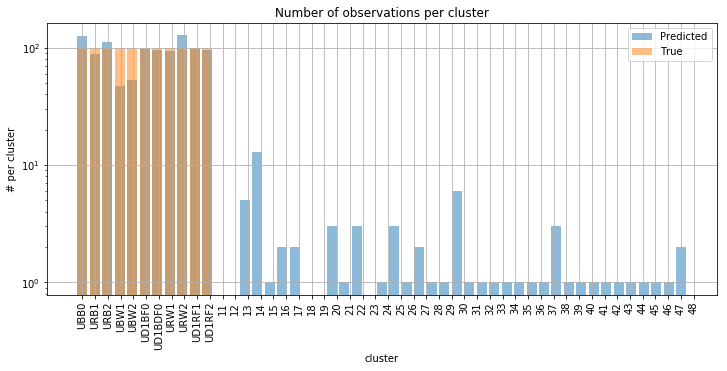

In [59]:
# Visualize the image identification
from scipy import stats
show_cluster = False

model = AgglomerativeClustering(n_clusters=ncltc, 
                                  affinity=metric, 
                                  linkage=method,
                                  distance_threshold=None, 
                                  compute_full_tree=False)
#desc_mat_std = scaler.fit(desc_mat)
clusters = model.fit(desc_mat)
clt_pred = clusters.labels_

unord_clt = []
new_clt_pred = clt_pred

for ind, ndim in enumerate(len_list):
    istart    = sum(len_list[:ind])
    ifinish   = sum(len_list[:ind+1])
    lst_clt   = list(new_clt_pred[istart:ifinish])
    lst_clt_b = list(new_clt_pred[:istart])
    lst_clt_f = list(new_clt_pred[ifinish:])
    arr_clt   = np.array(lst_clt)
    mode      = stats.mode(arr_clt).mode[0]
    lst_clt   = [ind if c==mode else c for c in lst_clt]
    lst_clt_f = [ind if c==mode else c for c in lst_clt_f]
    new_clt_pred = lst_clt_b + lst_clt + lst_clt_f
    
if show_cluster==True:
    print('Cluster true:\n',clt_true)    
    print('Cluster predicted:\n',new_clt_pred)

lab_tup = tuple(im_labels+list(np.arange(len(len_list),ncltc)))

plt.clf()
fig = plt.figure(figsize=(12,5))
_, bins, _ = plt.hist(new_clt_pred, bins=ncltc, alpha=0.5, rwidth=0.80, align='left', label='Predicted')
_ = plt.hist(clt_true, bins=bins, alpha=0.5, rwidth=0.80, align='left', label='True')
plt.legend()
plt.title('Number of observations per cluster')
plt.ylabel('# per cluster')
plt.xlabel('cluster')
plt.yscale('log')
plt.xticks(np.arange(ncltc),lab_tup,rotation='vertical',fontsize=10)
plt.grid()
fig.show()

PRF = precision_recall_fscore_support(clt_true, new_clt_pred, average='weighted')
precision = PRF[0]
recall = PRF[1]
fscore = PRF[2]

print('N-clusters: %5i' % ncltc)
print('Precision : %.5f' % precision)
print('Recall    : %.5f' % recall)
print('F1 score  : %.5f' % fscore)